<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#!pip3 install catboost

In [2]:
#!pip install torchvision 

In [3]:
#!pip install transformers

In [4]:
#!pip install pymystem3

In [5]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    r2_score,
    precision_score,
    mean_squared_error,
    mean_absolute_error,
    recall_score
)
from pymystem3 import Mystem
from tqdm.notebook import tqdm
import torch
import transformers
from tqdm import notebook

from time import time
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams ['figure.figsize'] = [10, 4]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\almuc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\almuc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
try:
    data = pd.read_csv('C:/Users/almuc/Downloads/toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [7]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


В таблице 159292 строки и 3 столбца. Пропусков нет.

Приведем столбец text к строчному формату.

In [9]:
data['text'] = data['text'].str.lower()

In [10]:
data.head()

,Unnamed: 0,text,toxic
0,0,explanation\nwhy the edits made under my usern...,0
1,1,d'aww! he matches this background colour i'm s...,0
2,2,"hey man, i'm really not trying to edit war. it...",0
3,3,"""\nmore\ni can't make any real suggestions on ...",0
4,4,"you, sir, are my hero. any chance you remember...",0


Проведем проверку на наличие явных дубликатов.

In [11]:
print('Количество явных дубликатов', data.duplicated().sum())

Количество явных дубликатов 0


Явные дубликаты не выявлены.

Посмотрим на соотношение позитивных и негативных комментариев.

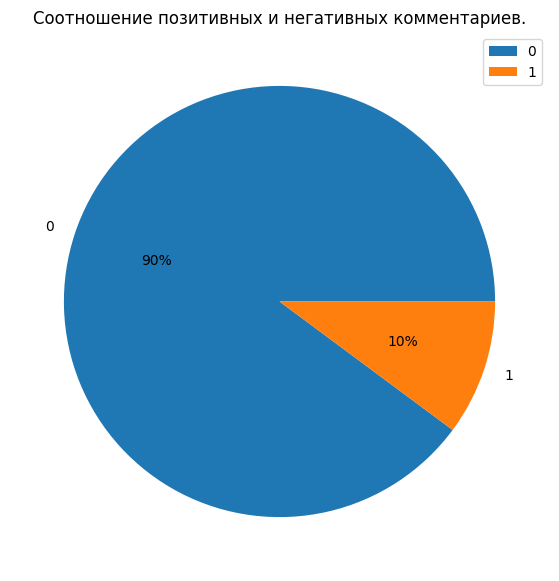

In [12]:
data.pivot_table(index='toxic',values='Unnamed: 0',aggfunc='count') \
  .plot.pie(y='Unnamed: 0', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение позитивных и негативных комментариев.")
plt.show()

В датафрейме отсутствуют явные дубликаты. 10 % комментариев имеют негативный смысл, а также столбец text был приведен к нижнему регистру.

In [13]:
#data['text'] = data['text'].values.astype('U')

In [14]:
%%time

lemmatize = nltk.WordNetLemmatizer()

def cleaning(row):
    text = re.sub('[^a-zA-Z]', '    ', row.text) # удаляем неалфавитные символы
    text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
    text = [lemmatize.lemmatize(word) for word in text] # лемматирзируем слова
    row['clear_text'] = ' '.join(text) # соединяем слова
    return row

data = data.apply(cleaning, axis=1)

CPU times: total: 4min 54s
Wall time: 4min 55s


In [15]:
data.head(10)

,Unnamed: 0,text,toxic,clear_text
0,0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,1,d'aww! he matches this background colour i'm s...,0,d aww he match this background colour i m seem...
2,2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...
3,3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...
5,5,"""\n\ncongratulations from me as well, use the ...",0,congratulation from me a well use the tool wel...
6,6,cocksucker before you piss around on my work,1,cocksucker before you piss around on my work
7,7,your vandalism to the matt shirvington article...,0,your vandalism to the matt shirvington article...
8,8,sorry if the word 'nonsense' was offensive to ...,0,sorry if the word nonsense wa offensive to you...
9,9,alignment on this subject and which are contra...,0,alignment on this subject and which are contra...


Удалим столбец text.

In [16]:
data = data.drop(['text'], axis=1)

In [17]:
data.head()

,Unnamed: 0,toxic,clear_text
0,0,0,explanation why the edits made under my userna...
1,1,0,d aww he match this background colour i m seem...
2,2,0,hey man i m really not trying to edit war it s...
3,3,0,more i can t make any real suggestion on impro...
4,4,0,you sir are my hero any chance you remember wh...


Думаю нам также не нужен столбец Unnamed: 0

In [18]:
data = data.drop(['Unnamed: 0'], axis=1)

In [19]:
data.head()

,toxic,clear_text
0,0,explanation why the edits made under my userna...
1,0,d aww he match this background colour i m seem...
2,0,hey man i m really not trying to edit war it s...
3,0,more i can t make any real suggestion on impro...
4,0,you sir are my hero any chance you remember wh...


Теперь проверим текст на наличие дуликатов.

In [20]:
print('Количество явных дубликатов', data.duplicated().sum())

Количество явных дубликатов 1307


Удалим дубликаты.

In [21]:
data = data.drop_duplicates()

In [22]:
print('Количество явных дубликатов', data.duplicated().sum())

Количество явных дубликатов 0


Дубликаты удалены.

Проведем сброс индекса.

In [23]:
data = data.reset_index(drop=True)

In [24]:
X = data.drop('toxic', axis=1)
y = data['toxic']

In [25]:
features_train, features_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42)

In [26]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))

X_train = count_tf_idf.fit_transform(features_train['clear_text'])
X_test = count_tf_idf.transform(features_test['clear_text'])
print(X_train.shape)
print(X_test.shape)
cv_counts = 2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\almuc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(126388, 138209)
(31597, 138209)


При подготовке данных к прогнозированию было сделано следующее:
1. Проведена очистка данных и проведена лемматизация текста. Данные были сохранены в новый столбец.
2. Удалены столбцы Unnamed: 0 и text.
3. Удалено 797 дубликатов.
4. Разделены данные на тренировочную и тестовую выборку в соотношение 80/20 и проведена соразмерность данных.

## Обучение

**Классификатор LogisticRegression**

In [27]:
%%time

classificator = LogisticRegression()
parameters = {'C': np.linspace(0.01, 500, 5),'class_weight':['balanced']}

model_lr = GridSearchCV(estimator=LogisticRegression(),param_grid = parameters, n_jobs=-1,cv=5, scoring='f1')
model_lr.fit(X_train, y_train)
start = time()
model_lr.best_estimator_.fit(X_train, y_train)
end = time()
time_lr = (end-start)

mse_model_lr = model_lr.best_score_
print("Оптимальная комбинация гиперпараметров LogisticRegression:", model_lr.best_params_)
print()
print("f1 модели LogisticRegression:", mse_model_lr)

start1 = time()
preds_model_lr = model_lr.best_estimator_.predict(X_train)

end1 = time()
time_lr_pred = (end1-start1)

Оптимальная комбинация гиперпараметров LogisticRegression: {'C': 125.00750000000001, 'class_weight': 'balanced'}

f1 модели LogisticRegression: 0.7434515458166059
CPU times: total: 11.3 s
Wall time: 59.6 s


**Классификатор DecisionTreeClassifier**

In [28]:
%%time
classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(5,10,2)],
                'random_state':[1515],
                'class_weight':['balanced']}]


model_tr = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
model_tr.fit(X_train, y_train)

start = time()
model_tr.best_estimator_.fit(X_train, y_train)
end = time()
time_tr = (end-start)

mse_model_tr = model_tr.best_score_
print("Оптимальная комбинация гиперпараметров DecisionTreeRegressor:", model_tr.best_params_)
print()
print("f1 модели DecisionTreeRegressor:", mse_model_tr)

start1 = time()
preds_model_lr = model_lr.best_estimator_.predict(X_train)

end1 = time()
time_tr_pred = (end1-start1)

Оптимальная комбинация гиперпараметров DecisionTreeRegressor: {'class_weight': 'balanced', 'max_depth': 9, 'random_state': 1515}

f1 модели DecisionTreeRegressor: 0.5403957155340855
CPU times: total: 1min 6s
Wall time: 1min 6s


**Классификатор CatBoostClassifier**

In [29]:
%%time
classificator = CatBoostClassifier()
hyperparams = [{'max_depth':[x for x in range(1,10,18)],
                'random_state':[1515]}]

model_cat = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
model_cat.fit(X_train, y_train)

start = time()
model_cat.best_estimator_.fit(X_train, y_train)
end = time()
time_cat = (end-start)

mse_model_cat = model_cat.best_score_
print("Оптимальная комбинация гиперпараметров CatBoostRegressor:", model_cat.best_params_)
print()
print("f1 модели CatBoostRegressor:", mse_model_cat)

start1 = time()
preds_model_cat = model_cat.best_estimator_.predict(X_train)

end1 = time()
time_cat_pred = (end1-start1)

Learning rate set to 0.060509
0:	learn: 0.6365194	total: 297ms	remaining: 4m 56s
1:	learn: 0.5879709	total: 414ms	remaining: 3m 26s
2:	learn: 0.5462211	total: 537ms	remaining: 2m 58s
3:	learn: 0.5106914	total: 654ms	remaining: 2m 42s
4:	learn: 0.4802063	total: 776ms	remaining: 2m 34s
5:	learn: 0.4546294	total: 891ms	remaining: 2m 27s
6:	learn: 0.4323965	total: 1.01s	remaining: 2m 23s
7:	learn: 0.4122660	total: 1.13s	remaining: 2m 20s
8:	learn: 0.3956475	total: 1.25s	remaining: 2m 17s
9:	learn: 0.3808663	total: 1.37s	remaining: 2m 15s
10:	learn: 0.3676697	total: 1.49s	remaining: 2m 13s
11:	learn: 0.3569878	total: 1.61s	remaining: 2m 12s
12:	learn: 0.3478962	total: 1.73s	remaining: 2m 11s
13:	learn: 0.3396512	total: 1.84s	remaining: 2m 9s
14:	learn: 0.3326003	total: 1.96s	remaining: 2m 8s
15:	learn: 0.3260110	total: 2.08s	remaining: 2m 7s
16:	learn: 0.3197783	total: 2.2s	remaining: 2m 7s
17:	learn: 0.3142984	total: 2.32s	remaining: 2m 6s
18:	learn: 0.3100117	total: 2.45s	remaining: 2m 6s

**Классификатор RandomForestClassifier**

In [30]:
%%time
classificator = RandomForestClassifier()
hyperparams = {'n_estimators': ([x for x in range(10, 30)]),
              'random_state': ([12345]),
              'max_depth': ([x for x in range(1, 10)]),
              'criterion': (['entropy']),
              'class_weight': (['balanced'])}


model_ran = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
model_ran.fit(X_train, y_train)

start = time()
model_ran.best_estimator_.fit(X_train, y_train)
end = time()
time_ran = (end-start)

mse_model_ran = model_ran.best_score_
print("Оптимальная комбинация гиперпараметров RandomForestClassifier:", model_ran.best_params_)
print()
print("f1 модели RandomForestClassifier:", mse_model_ran)

start1 = time()
preds_model_ran = model_ran.best_estimator_.predict(X_train)

end1 = time()
time_ran_pred = (end1-start1)

Оптимальная комбинация гиперпараметров RandomForestClassifier: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 29, 'random_state': 12345}

f1 модели RandomForestClassifier: 0.3305714178979315
CPU times: total: 12min 49s
Wall time: 12min 50s


**Вывод по классификаторам**

In [31]:
toxic = [[time_lr, time_lr_pred, mse_model_lr],
        [time_tr, time_tr_pred, mse_model_tr],
        [time_cat, time_cat_pred, mse_model_cat],
        [time_ran, time_ran_pred, mse_model_ran]]
model_toxic = ["Linear Regression", "DecisionTreeRegressor", "CatBoostRegressor", "RandomForestClassifier"]
scores_data = pd.DataFrame(data=toxic, index=model_toxic, columns=["fit_time", "predict_time", "f1"])
scores_data['Выполнение задачи'] = scores_data['f1'] > 0.75
scores_data

,fit_time,predict_time,f1,Выполнение задачи
Linear Regression,5.425280,0.012991,0.743452,False
DecisionTreeRegressor,5.941824,0.012998,0.540396,False
CatBoostRegressor,253.006123,0.835412,0.627248,False
RandomForestClassifier,1.082242,0.753469,0.330571,False


Было обучено 4 модели:
- LogisticRegression с параметром F1 на кросс-валидации 0,74,
- DecisionTreeClassifier с параметром F1 на кросс-валидации 0,55,
- CatBoostClassifier с параметром F1 на кросс-валидации 0,65,
- RandomForestClassifier с параметром F1 на кросс-валидации 0,33.

Толька одна модель LogisticRegression близка к требованию F1 на кросс-валидации больше 0,75. 

Проверим лучшую модель на тестовых данных.

In [32]:
%%time
start = time()
lr_predict1 = model_lr.best_estimator_.predict(X_test)
end = time()
time_lr_pred1 = (end-start)

CPU times: total: 0 ns
Wall time: 5 ms


In [33]:
mse_model_lr_test = f1_score(y_test, lr_predict1)
print(f'f1 = {mse_model_lr_test:.2f}')

f1 = 0.76


In [34]:
# посчитаем ошибки
mae_lr = mean_absolute_error(lr_predict1, y_test)
mse_lr = mean_squared_error(lr_predict1, y_test)
rmse_lr = mean_squared_error(lr_predict1, y_test, squared=False) 
r2_lr = r2_score(y_test, lr_predict1)

# выведем ошибки
print(f"R2 LogisticRegressor = {r2_lr:.2f}")
print(f"RSME = {rmse_lr:.2f}")
print(f'MSE = {mse_lr:.2f}')
print(f'MAE = {mae_lr:.2f}')
#Сравним первые строки прогноза с реальным значением
print('Прогнозируемое значение (первая строка) = ', lr_predict1[0], 'Реальное значение (первая строка) = ', y_test.reset_index(drop = True)[0])

R2 LogisticRegressor = 0.44
RSME = 0.23
MSE = 0.05
MAE = 0.05
Прогнозируемое значение (первая строка) =  0 Реальное значение (первая строка) =  0


Модель LogisticRegressor на тестовых данных показала следующие метрики:
- f1 = 0.76
- R2 LGBMRegressor = 0.44
- RSME = 0.23
- MSE = 0.05
- MAE = 0.05
- Прогнозируемое значение (первая строка) =  0 Реальное значение (первая строка) =  0
Требование заказчика по метрике f1 выполнено.

## Выводы

По итогам работы с классификация комментариев интернет-магазина «Викишоп» можно сделать следующие выводы:
1. В исходной таблице 159292 строки и 3 столбца. Пропусков нет.
2. В датафрейме отсутствуют явные дубликаты. 10 % комментариев имеют негативный смысл, а также столбец text был приведен к нижнему регистру.
3. При подготовке данных к прогнозированию было сделано следующее:
- Проведена очистка данных и проведена лемматизация текста. Данные были сохранены в новый столбец.
- Удалены столбцы Unnamed: 0 и text.
- Удалено 797 дубликатов.
- Разделены данные на тренировочную и тестовую выборку в соотношение 80/20 и проведена соразмерность данных.
4. Было обучено 4 модели:
- LogisticRegression с параметром F1 на кросс-валидации 0,74,
- DecisionTreeClassifier с параметром F1 на кросс-валидации 0,55,
- CatBoostClassifier с параметром F1 на кросс-валидации 0,65,
- RandomForestClassifier с параметром F1 на кросс-валидации 0,33.

Толька одна модель LogisticRegression близка к требованию F1 на валидации больше 0,75. 
5. Модель LogisticRegressor на тестовых данных показала следующие метрики:
- f1 = 0.76
- R2 LGBMRegressor = 0.44
- RSME = 0.23
- MSE = 0.05
- MAE = 0.05
- Прогнозируемое значение (первая строка) =  0 Реальное значение (первая строка) =  0

**Требование заказчика по метрике f1 выполнено.**

P.S. Была таке проведена попытка работы с Bert, на общем датафрейме время обучения выдало 58 часов, при семплировании на 10000 строк было время 4 часа. Метрику показала лучше, чем другие модели, но думаю она слишком трудозатратна поэтому здесь не стал ее представлять.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны